# Production Database Tests
The purpose of this notebook is to explore different ways to interact with the production database for the Sharing Ecosystem Assessment (SEA) program.
Before starting this test notebook it is important to have an instance of SQL Server Running and the database data_pipeline.mdf attached to this instance. 
1. Download SQL Server Express - https://www.microsoft.com/en-us/sql-server/sql-server-downloads 2. 
Download SQL Server Management Studio (SSMS) - https://learn.microsoft.com/en-us/sql/ssms/download-sql-server-management-studio-ssms?view=sql-server-ver1
3. Link Database available at https://github.com/sandersa-nist/sea_db_testdrive
4. 
Right click on Databases in SSMS and click “Attach…” and select the .mdf file for the database you want to attach. As shown in the attached png, you will see a message complaining the Transaction log file not found. Click on the data_pipeline_log.ldf and click the remove button and then click OK to attach thdatabase 5 
3. Make sure Driver string is correct (ODBC Driver 17 for SQL Serv for the pyodbc bridgee?es 

## Imports

In [1]:
import pyodbc 
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Watermark
%load_ext watermark
%watermark
%watermark --iversions

Last updated: 2024-03-07T22:42:32.660006-07:00

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.9.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit

seaborn   : 0.13.2
pandas    : 1.5.3
numpy     : 1.26.2
matplotlib: 3.6.3
pyodbc    : 5.1.0



## Constants

In [3]:
time_domain = {"name":"time_domain","description":"Time Domain Power",
               "x_units":"Time (S)","y_units":"dBm","length":400,"x_start":0,"x_stop":3.99}
pfp = {"name":"pfp","description":"Periodic Frame Power","x_units":"Time (S)","y_units":"dBm","length":560,"x_start":0,"x_stop":0.009982142857142856}
psd = {"name":"psd","description":"Power Spectral Denisty",
       "x_units":"Frequency (Hz)","y_units":"dBm/Hz","length":125,"x_start":-5000,"x_stop":5000}
apd = {"name":"apd","description":"Power Spectral Density",
       "x_units":"Percent Exceeding Ordinal","y_units":"dBm","y_length":151,"y_start":-180,"y_stop":-30}

## Class Definitions
Here we define a client class for interacting with the database and a plotter class for visualizations. The intended use is
```python
new_client = ProductionDBClient(driver = '{ODBC Driver 17 for SQL Server}',server = '675NASCTNLAP3',database = 'data_pipeline')
new_plotter = ProductionDBPlotter(new_client)
```

In [4]:

class ProductionDBClient():
    def __init__(self,driver = '{ODBC Driver 17 for SQL Server}',server = '675NASCTNLAP3',database = 'data_pipeline',**options):
        connection_string = f"""Driver={driver};
                              Server={server};
                              Database={database};
                              Trusted_Connection=yes;"""
        self.connection = pyodbc.connect(connection_string)
        self.tables = pd.read_sql('SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES', self.connection)
        self.sensors = self.get_table('dbo.sensors')
        
    def get_table(self,table):
        return pd.read_sql(f"SELECT * FROM {table}", self.connection)

    def get_joined_summary_table(self):
        query_string = """SELECT *
                        FROM channel_summary
                        INNER JOIN channel_status ON channel_summary.acquisition_id=channel_status.acquisition_id AND channel_summary.channel_id=channel_status.channel_id;"""
        df = pd.read_sql(query_string, self.connection)
        df = df.loc[:,~df.columns.duplicated()].copy()
        return df
        
    def get_joined_summary_table_by_sensor(self,sensor_id):
        query_string = f"""SELECT *
            FROM channel_status 
            INNER JOIN channel_summary 
            ON channel_status.acquisition_id=channel_summary.acquisition_id AND channel_status.channel_id=channel_summary.channel_id
            WHERE sensor_id={sensor_id};"""
        df = pd.read_sql(query_string, self.connection)
        df = df.loc[:,~df.columns.duplicated()].copy()
        return df
        
    def get_joined_summary_table_by_date_sensor(self,start_date,stop_date,sensor_id):
        query_string = f"""SELECT *
            FROM channel_status 
            INNER JOIN channel_summary 
            ON channel_status.acquisition_id=channel_summary.acquisition_id AND channel_status.channel_id=channel_summary.channel_id
            Where acquisition_timestamp between '{start_date}' and '{stop_date}' AND sensor_id = {sensor_id};"""
        df = pd.read_sql(query_string, self.connection)
        df = df.loc[:,~df.columns.duplicated()].copy()
        return df   
        
    def get_joined_summary_table_by_sensor_channel(self,sensor_id,channel_id):
        query_string = f"""SELECT *
            FROM channel_status 
            INNER JOIN channel_summary 
            ON channel_status.acquisition_id=channel_summary.acquisition_id AND channel_status.channel_id=channel_summary.channel_id
            WHERE sensor_id={sensor_id} AND channel_status.channel_id = {channel_id};"""
        df = pd.read_sql(query_string, self.connection)
        df = df.loc[:,~df.columns.duplicated()].copy()
        return df
        
    def query(self,query:str):
        """Raw SQL string query"""
        cursor = self.connection.cursor()
        rows = cursor.execute(f"{query}").fetchall()
        return list(rows)
        
    def dataframe_query(self,query:str):
        """SQL string query that returns a pandas dataframe"""
        return pd.read_sql(query, self.connection)

    def get_acquistion_ids_by_date_range(self,start_date,stop_date,sensor_id):
        df = pd.read_sql(f"""SELECT acquisition_id FROM dbo.channel_status 
                            Where acquisition_timestamp between '{start_date}' and '{stop_date}' AND sensor_id = {sensor_id}""", 
                         self.connection)
        return df["acquisition_id"].unique()

    def get_preselector_diagnostic_by_sensor(self,sensor_id):
        query_string=f"""SELECT *
            FROM diagnostics
            INNER JOIN preselector ON diagnostics.diagnostic_id=preselector.diagnostic_id
            WHERE sensor_id = {sensor_id}"""
        df = pd.read_sql(query_string, self.connection)
        df = df.loc[:,~df.columns.duplicated()].copy()
        return df

    def get_preselector_diagnostic_by_date_sensor(self,start_date, stop_date,sensor_id):
        query_string=f"""SELECT *
            FROM diagnostics
            INNER JOIN preselector ON diagnostics.diagnostic_id=preselector.diagnostic_id
            WHERE diagnostics.timestamp BETWEEN '{start_date}' AND '{stop_date}' AND sensor_id = {sensor_id}"""
        df = pd.read_sql(query_string, self.connection)
        df = df.loc[:,~df.columns.duplicated()].copy()
        return df
        
    def get_spu_diagnostic_by_date_sensor(self,start_date, stop_date,sensor_id):
        query_string=f"""SELECT *
            FROM diagnostics
            INNER JOIN spu ON diagnostics.diagnostic_id=spu.diagnostic_id
            WHERE diagnostics.timestamp BETWEEN '{start_date}' AND '{stop_date}' AND sensor_id = {sensor_id}"""
        df = pd.read_sql(query_string, self.connection)
        df = df.loc[:,~df.columns.duplicated()].copy()
        return df
        
    def get_spu_diagnostic_by_sensor(self,sensor_id):
        query_string=f"""SELECT *
            FROM diagnostics
            INNER JOIN spu ON diagnostics.diagnostic_id=spu.diagnostic_id
            WHERE sensor_id = {sensor_id}"""
        df = pd.read_sql(query_string, self.connection)
        df = df.loc[:,~df.columns.duplicated()].copy()
        return df
        
    def get_frequencies(self):
        df = self.get_table('channel')
        return df["center_frequency"]

In [5]:
class ProductionDBPlotter():
    def __init__(self,client: ProductionDBClient):
        self.client = client
        
    def plot_summary(self):
        summary_table = self.client.get_joined_summary_table()
        sns.jointplot(x = "true_median", y = "max_max", 
              hue="overload",data = summary_table) 
        plt.grid()
        plt.show()
        
    def plot_summary_by_sensor(self,sensor_id):
        summary_table = self.client.get_joined_summary_table_by_sensor(sensor_id)
        sns.jointplot(x = "true_median", y = "max_max", 
              hue="overload",data = summary_table)
        fig = plt.gcf()
        fig.suptitle(f"Sensor:{sensor_id}")
        plt.grid()
        plt.show()

    def plot_summary_by_sensor_channel(self,sensor_id,channel_id):
        summary_table = self.client.get_joined_summary_table_by_sensor_channel(sensor_id,channel_id)
        sns.jointplot(x = "true_median", y = "max_max", 
              hue="overload",data = summary_table)
        fig = plt.gcf()
        fig.suptitle(f"Sensor:{sensor_id} Channel:{channel_id}")
        plt.grid()
        plt.show()
        
    def plot_time_by_sensor(self,sensor_id,channel_start=0,channel_stop=20,stream="max_max"):
        summary_table = self.client.get_joined_summary_table_by_sensor(sensor_id)
        for channel in range(channel_start,channel_stop+1):
            try:
                selected_data = summary_table[summary_table["channel_id"] ==channel]
                if not selected_data.empty:
                    plt.plot(selected_data['acquisition_timestamp'],selected_data[stream],".",label=channel,rasterized=True)
            except:
                raise
        fig = plt.gcf()
        fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
        fig.suptitle(f"Sensor:{sensor_id}, Data Stream:{stream}")
        plt.grid()
        ax=plt.gca()
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.ylabel("Power (dBm)")
        fig.patch.set_facecolor('white')
        plt.show()
        
    def plot_time_by_sensor_channel(self,sensor_id,channel_id,stream="max_max"):
        summary_table = self.client.get_joined_summary_table_by_sensor_channel(sensor_id,channel_id)
        plt.plot(summary_table['acquisition_timestamp'],summary_table[stream],".",rasterized=True)
        fig = plt.gcf()
        fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
        fig.suptitle(f"Sensor:{sensor_id}, Channel:{channel_id}, Data Stream:{stream}")
        plt.ylabel("Power (dBm)")
        fig.patch.set_facecolor('white')

        plt.grid()
        plt.show()
        
    def plot_preselector_diagnostic_temps_by_sensor(self,sensor_id):
        summary_table = self.client.get_preselector_diagnostic_by_sensor(sensor_id)
        diagnostic_fields = ['lna_temp','noise_diode_temp','temp']
        for diagnostic in diagnostic_fields:
            plt.plot(summary_table['timestamp'],summary_table[diagnostic],label = diagnostic)
        fig=plt.gcf()
        fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
        fig.suptitle(f"Preselector Sensor:{sensor_id}")
        plt.legend()
        plt.grid()
        plt.show()
        
    def plot_spu_diagnostic_temps_by_sensor(self,sensor_id):
        summary_table = self.client.get_spu_diagnostic_by_sensor(sensor_id)
        diagnostic_fields = ['internal_temp','sigan_internal_temp','tec_exhaust_temp','tec_intake_temp']
        for diagnostic in diagnostic_fields:
            plt.plot(summary_table['timestamp'],summary_table[diagnostic],label = diagnostic)
        fig=plt.gcf()
        fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
        fig.suptitle(f"SPU Sensor:{sensor_id}")
        fig.patch.set_facecolor('white')
        plt.legend()
        plt.grid()
        plt.show()

    def plot_strip(self,sensor_id,stream="max_max"):
        summary_table = self.client.get_joined_summary_table_by_sensor(sensor_id)
        fig=plt.gcf()
        fig.suptitle(f"Sensor:{sensor_id}")
        sns.stripplot(data=summary_table, x="channel_id", y=stream,hue='overload')
        plt.grid()
        
    def plot_strip_by_date(self,start_date,stop_date,sensor_id,stream="max_max"):
        summary_table = self.client.get_joined_summary_table_by_date_sensor(start_date,stop_date,sensor_id)
        fig=plt.gcf()
        fig.suptitle(f"Sensor:{sensor_id}, Between {start_date} and {stop_date}")
        sns.stripplot(data=summary_table, x="channel_id", y=stream,hue='overload')
        fig.patch.set_facecolor('white')
        plt.grid()
        
    def plot_papr_by_date(self,start_date,stop_date,sensor_id):
        summary_table = self.client.get_joined_summary_table_by_date_sensor(start_date,stop_date,sensor_id)
        summary_table['papr'] = summary_table['max_max']-summary_table["true_mean"]
        fig=plt.gcf()
        fig.suptitle(f"Sensor:{sensor_id}, Between {start_date} and {stop_date}")
        sns.stripplot(data=summary_table, x="channel_id", y="papr",hue='overload')
        fig.patch.set_facecolor('white')
        plt.grid()

    def plot_value_frequency_by_date(self,start_date,stop_date,sensor_id,stream = "max_max",cmap ='magma' ):
        summary_table =  self.client.get_joined_summary_table_by_date_sensor(start_date,stop_date,sensor_id)
        image_ = []
        for id_ in sorted(summary_table["acquisition_id"].unique()):
            row = []
            for channel in sorted(summary_table["channel_id"].unique()):
                data_point = summary_table[(summary_table["acquisition_id"]==id_) & (summary_table["channel_id"]==channel)]
                try:
                    data_point_value = data_point[stream].values.tolist()[0]
                except:
                    data_point_value = data_point[stream].min()
                row.append(data_point_value)
            image_.append(row)
        aspect_ratio = len(image_[0])/len(image_)
        plt.imshow(image_,aspect=aspect_ratio,clim=(np.nanmin(image_),  np.nanmax(image_)),origin='lower',cmap=cmap)
        plt.xticks(np.array(range(len(image_[0])))-.5, sorted(summary_table["channel_id"].unique()), rotation='horizontal')
        plt.yticks([0,len(image_)], [min(summary_table["acquisition_timestamp"]),max(summary_table["acquisition_timestamp"])], rotation=30)
        plt.colorbar()
        plt.xlabel("Channel")
        fig=plt.gcf()
        fig.suptitle(f"Sensor:{sensor_id}, {stream}, Between {start_date} and {stop_date}")
        plt.grid()
        
    def plot_data_by_acquistion_channel(self,acquisition_id,channel_id,table = "psd_max" ):
        """For use with pfp,psd, and time_domain data"""
        query_string = f"""SELECT * FROM {table}
                        WHERE acquisition_id = {acquisition_id} AND channel_id = {channel_id}"""
        data_stream =  self.client.dataframe_query(query_string)
        if "pfp" in table:
            x_data = np.linspace(pfp["x_start"],pfp["x_stop"],pfp["length"])
            y_data = data_stream[[f"pfp_{i+1}" for i in range(pfp["length"])]].T
            x_units = pfp["x_units"]
            y_units = pfp["y_units"]
        elif "time" in table:
            x_data = np.linspace(time_domain["x_start"],time_domain["x_stop"],time_domain["length"])
            y_data = data_stream[[f"time_{i+1}" for i in range(time_domain["length"])]].T
            x_units = time_domain["x_units"]
            y_units = time_domain["y_units"]
        elif "psd" in table:
            x_data = np.linspace(psd["x_start"],psd["x_stop"],psd["length"])
            y_data = data_stream[[f"psd_{i+1}" for i in range(psd["length"])]].T
            x_units = psd["x_units"]
            y_units = psd["y_units"]
        plt.plot(x_data,y_data)
        plt.ylabel(f"Power ({y_units})")
        plt.xlabel(f"{x_units}")
        fig=plt.gcf()
        fig.suptitle(f"Acquisition:{acquisition_id}, Channel:{channel_id}, {table}")
        plt.grid()

In [6]:
new_client = ProductionDBClient()
new_plotter = ProductionDBPlotter(new_client)

# Database Interactions
The basic flow is that you connect a client and use either a sql query string or a method with the query string already defined. Above we have defined the client as `new_client`.  The following examples show
1. How to discover all of the availble tables (new_client.tables)
2. How to get the contents of any table as a pandas dataframe (new_client.get_table(table))
3. How to use the query method to send a SQL string based query and receive a list of tuples (new_client.query("SELECT * FROM channel"))
4. How to use the dataframe_query method (new_client.dataframe_query("SELECT * FROM channel"))
5. How to generate a joined summary table using the get_joined_summary_table_by_date_sensor method.
6. A small portion of every table.

In [7]:
# The new_client instance has the attribute tables that is a listing of all of the availible tables
new_client.tables

,TABLE_NAME
0,apd
1,channel
2,channel_status
3,channel_summary
4,computer
5,dft
6,diagnostics
7,digital_filter
8,hardware_revision
9,pfp_mean_max


In [8]:
# to retrieve the contents of any table as a pandas data frame use the method get_table
new_client.get_table('channel')

,channel_id,center_frequency,channel_bandwidth,duration,sample_rate
0,1,3.515000e+09,10000000.0,4000,14000000.0
1,2,3.525000e+09,10000000.0,4000,14000000.0
2,3,3.535000e+09,10000000.0,4000,14000000.0
3,4,3.545000e+09,10000000.0,4000,14000000.0
4,5,3.555000e+09,10000000.0,4000,14000000.0
5,6,3.565000e+09,10000000.0,4000,14000000.0
6,7,3.575000e+09,10000000.0,4000,14000000.0
7,8,3.585000e+09,10000000.0,4000,14000000.0
8,9,3.595000e+09,10000000.0,4000,14000000.0
9,10,3.605000e+09,10000000.0,4000,14000000.0


In [9]:
new_client.query("SELECT * FROM preselector")

[(1, True, True, 26.9, True, 26.6, False, False, 26.9, 26.6),
 (2, True, True, 27.2, True, 27.4, False, False, 27.2, 27.4),
 (3, True, True, 27.3, True, 27.4, False, False, 27.3, 27.4),
 (4, True, True, 27.3, True, 27.3, False, False, 27.3, 27.3),
 (5, True, True, 27.3, True, 27.3, False, False, 27.3, 27.3),
 (6, True, True, 27.3, True, 27.2, False, False, 27.3, 27.2),
 (7, True, True, 27.3, True, 27.2, False, False, 27.3, 27.2),
 (8, True, True, 27.3, True, 27.1, False, False, 27.3, 27.1),
 (9, True, True, 27.3, True, 27.1, False, False, 27.3, 27.1),
 (10, True, True, 27.3, True, 27.1, False, False, 27.3, 27.1),
 (11, True, True, 27.3, True, 27.1, False, False, 27.3, 27.1),
 (12, True, True, 27.3, True, 27.1, False, False, 27.3, 27.1),
 (13, True, True, 27.3, True, 27.1, False, False, 27.3, 27.1),
 (14, True, True, 27.3, True, 27.0, False, False, 27.3, 27.0),
 (15, True, True, 27.3, True, 27.0, False, False, 27.3, 27.0),
 (16, True, True, 27.2, True, 27.0, False, False, 27.2, 27.0),
 

In [10]:
new_client.dataframe_query("SELECT * FROM preselector")

,diagnostic_id,antenna_path_enabled,door_closed,humidity,lna_powered,lna_temp,noise_diode_path_enabled,noise_diode_powered,noise_diode_temp,temp
0,1,True,True,26.9,True,26.6,False,False,26.9,26.6
1,2,True,True,27.2,True,27.4,False,False,27.2,27.4
2,3,True,True,27.3,True,27.4,False,False,27.3,27.4
3,4,True,True,27.3,True,27.3,False,False,27.3,27.3
4,5,True,True,27.3,True,27.3,False,False,27.3,27.3
...,...,...,...,...,...,...,...,...,...,...
474,475,True,True,26.6,True,26.4,False,False,26.6,26.4
475,476,True,True,26.6,True,26.4,False,False,26.6,26.4
476,477,True,True,26.5,True,26.4,False,False,26.5,26.4
477,478,True,True,26.5,True,26.3,False,False,26.5,26.3


In [11]:
new_client.get_joined_summary_table_by_date_sensor(start_date="2024-02-15 05:00:00",
                                                   stop_date="2024-02-15 07:00:00",
                                                   sensor_id=1)

,acquisition_id,channel_id,acquisition_timestamp,calibration_id,overload,sensor_id,setting_id,max_max,median_mean,true_mean,true_median
0,406,13,2024-02-15 05:00:03.583,217,False,1,1,-67.4375,-95.1250,-94.9375,-99.7500
1,406,14,2024-02-15 05:00:09.056,218,False,1,1,-72.1250,-94.5625,-94.0000,-99.1250
2,406,15,2024-02-15 05:00:14.781,219,False,1,1,-76.1875,-95.4375,-95.4375,-99.4375
3,406,16,2024-02-15 05:00:21.212,220,False,1,1,-87.1875,-99.6875,-99.6875,-101.2500
4,406,17,2024-02-15 05:00:25.971,221,False,1,1,-87.3750,-99.9375,-99.9375,-101.5625
...,...,...,...,...,...,...,...,...,...,...,...
1109,468,6,2024-02-15 06:59:36.126,246,False,1,1,-85.1875,-99.6250,-99.6250,-101.1875
1110,468,7,2024-02-15 06:59:40.947,247,False,1,1,-87.4375,-99.8125,-99.8125,-101.4375
1111,468,8,2024-02-15 06:59:46.508,248,False,1,1,-86.8125,-100.0000,-100.0000,-101.5625
1112,468,9,2024-02-15 06:59:52.344,249,False,1,1,-86.9375,-99.8125,-99.8125,-101.4375


In [12]:
# All tables
from IPython.display import display, HTML

for table in new_client.tables["TABLE_NAME"]:
    print(table)
    print('*'*80)
    display(new_client.get_table(table).head())

apd
********************************************************************************


,acquisition_id,channel_id,filter,prob_1,prob_10,prob_100,prob_101,prob_102,prob_103,prob_104,...,prob_90,prob_91,prob_92,prob_93,prob_94,prob_95,prob_96,prob_97,prob_98,prob_99
0,4,5,1,1.0,1.0,1.013279e-06,5.960464e-08,0.0,0.0,0.0,...,0.254150,0.178345,0.114075,0.065063,0.032074,0.013168,0.004295,0.001045,0.000178,0.000020
1,4,6,1,1.0,1.0,1.370907e-06,5.960464e-08,0.0,0.0,0.0,...,0.260986,0.184204,0.118896,0.068481,0.034241,0.014328,0.004776,0.001194,0.000212,0.000024
2,4,7,1,1.0,1.0,4.768372e-07,0.000000e+00,0.0,0.0,0.0,...,0.236816,0.163086,0.102051,0.056488,0.026871,0.010529,0.003237,0.000735,0.000117,0.000011
3,4,8,1,1.0,1.0,7.748604e-07,0.000000e+00,0.0,0.0,0.0,...,0.241333,0.166992,0.105103,0.058655,0.028168,0.011177,0.003494,0.000814,0.000129,0.000013
4,4,9,1,1.0,1.0,7.748604e-07,0.000000e+00,0.0,0.0,0.0,...,0.245117,0.170288,0.107727,0.060547,0.029297,0.011757,0.003723,0.000878,0.000145,0.000014


channel
********************************************************************************


,channel_id,center_frequency,channel_bandwidth,duration,sample_rate
0,1,3.515000e+09,10000000.0,4000,14000000.0
1,2,3.525000e+09,10000000.0,4000,14000000.0
2,3,3.535000e+09,10000000.0,4000,14000000.0
3,4,3.545000e+09,10000000.0,4000,14000000.0
4,5,3.555000e+09,10000000.0,4000,14000000.0


channel_status
********************************************************************************


,acquisition_id,channel_id,acquisition_timestamp,calibration_id,overload,sensor_id,setting_id
0,4,5,2024-02-14 15:35:47.149,1,False,1,1
1,4,6,2024-02-14 15:35:53.578,2,False,1,1
2,4,7,2024-02-14 15:35:58.303,3,False,1,1
3,4,8,2024-02-14 15:36:03.564,4,False,1,1
4,4,9,2024-02-14 15:36:09.038,5,False,1,1


channel_summary
********************************************************************************


,acquisition_id,channel_id,max_max,median_mean,true_mean,true_median
0,4,5,-79.6250,-92.3750,-92.3750,-93.9375
1,4,6,-78.8750,-92.3125,-92.3125,-93.8750
2,4,7,-79.9375,-92.5625,-92.5625,-94.1875
3,4,8,-80.0625,-92.5000,-92.5000,-94.1250
4,4,9,-80.0625,-92.5000,-92.5000,-94.0625


computer
********************************************************************************


,diagnostic_id,action_cpu_usage,action_runtime,cpu_max_clock,cpu_mean_clock,cpu_min_clock,cpu_overheating,cpu_temp,cpu_uptime,memory_usage,software_start,software_uptime,system_load_5m
0,1,51.2,87.69,4374.8,3437.9,1770.0,False,58.0,14.01,14.9,2024-02-14 15:28:04.027,0.0064,18.8
1,2,52.6,102.77,4385.5,3336.9,1981.4,False,56.0,14.03,14.3,2024-02-14 16:05:17.032,0.0080,49.2
2,3,52.8,103.97,4100.0,3307.1,1906.4,False,58.0,14.03,14.3,2024-02-14 16:05:17.032,0.0092,49.9
3,4,53.2,103.55,4265.3,3521.9,1917.3,False,63.0,14.03,14.3,2024-02-14 16:05:17.032,0.0104,52.5
4,5,53.5,103.59,4172.2,3615.8,1467.7,False,60.0,14.04,14.4,2024-02-14 16:05:17.032,0.0116,54.0


dft
********************************************************************************


,id,baseband,description,dfts,equivalent_noise_bandwidth,name,samples,window
0,1,True,First and last 25 samples from 175-point FFT d...,320000,301619.72,psd_fft,175,flattop


diagnostics
********************************************************************************


,diagnostic_id,sensor_id,timestamp
0,1,1,2024-02-14 15:37:14.780
1,2,1,2024-02-14 16:16:48.850
2,3,1,2024-02-14 16:18:32.897
3,4,1,2024-02-14 16:20:16.524
4,5,1,2024-02-14 16:22:00.192


digital_filter
********************************************************************************


,id,attenuation_cutoff,description,feedforward_1,feedforward_10,feedforward_11,feedforward_12,feedforward_13,feedforward_2,feedforward_3,...,feedback_3,feedback_4,feedback_5,feedback_6,feedback_7,feedback_8,feedback_9,frequency_cutoff,name,type
0,1,40.0,5 MHz lowpass filter used as complex 10 MHz ba...,0.220018,22.284384,8.083698,1.895086,0.220018,1.895086,8.083698,...,19.199455,40.791248,63.24297,74.331108,67.698265,47.873253,26.149624,5008000.0,iir_1,IIR


hardware_revision
********************************************************************************


,hardware_revision_id,computer,noise_source,signal_analyzer
0,1,BTTN21000DH5,MY58230806,B022044


pfp_mean_max
********************************************************************************


,acquisition_id,channel_id,filter,pfp_1,pfp_10,pfp_100,pfp_101,pfp_102,pfp_103,pfp_104,...,pfp_90,pfp_91,pfp_92,pfp_93,pfp_94,pfp_95,pfp_96,pfp_97,pfp_98,pfp_99
0,4,5,1,-91.4375,-91.7500,-91.9375,-91.6875,-91.8125,-91.8125,-91.6875,...,-91.8125,-91.7500,-91.8125,-91.8125,-91.9375,-91.8125,-91.7500,-91.7500,-91.8125,-91.7500
1,4,6,1,-91.6875,-91.6875,-91.8125,-91.6875,-91.6250,-91.6250,-91.7500,...,-91.6875,-91.6250,-91.6250,-91.7500,-91.8125,-91.7500,-91.7500,-91.7500,-91.4375,-91.7500
2,4,7,1,-92.1250,-92.0625,-91.7500,-92.0625,-91.8750,-92.1250,-92.0625,...,-91.8750,-91.8125,-91.9375,-91.8750,-91.9375,-91.9375,-92.0625,-92.1250,-91.8750,-91.8750
3,4,8,1,-92.0000,-91.9375,-91.8125,-91.8750,-92.0625,-91.9375,-91.7500,...,-91.8125,-91.9375,-91.9375,-91.9375,-92.0000,-92.0625,-92.0000,-91.8125,-92.0625,-91.9375
4,4,9,1,-91.8125,-91.8750,-92.0000,-92.0000,-92.0000,-91.8750,-91.9375,...,-91.8125,-91.9375,-92.0000,-91.9375,-91.8750,-91.8125,-91.9375,-91.8750,-91.5625,-92.0000


pfp_mean_mean
********************************************************************************


,acquisition_id,channel_id,filter,pfp_1,pfp_10,pfp_100,pfp_101,pfp_102,pfp_103,pfp_104,...,pfp_90,pfp_91,pfp_92,pfp_93,pfp_94,pfp_95,pfp_96,pfp_97,pfp_98,pfp_99
0,4,5,1,-92.3125,-92.3125,-92.3750,-92.3750,-92.3750,-92.375,-92.3750,...,-92.3750,-92.3750,-92.3750,-92.3750,-92.3750,-92.3750,-92.3750,-92.3750,-92.3750,-92.3750
1,4,6,1,-92.2500,-92.3125,-92.3125,-92.2500,-92.3125,-92.250,-92.3125,...,-92.3125,-92.3125,-92.3125,-92.3125,-92.3125,-92.3125,-92.3125,-92.3125,-92.3125,-92.3125
2,4,7,1,-92.6250,-92.5625,-92.5625,-92.5625,-92.5625,-92.625,-92.6250,...,-92.5625,-92.5625,-92.6250,-92.5625,-92.6250,-92.5625,-92.5625,-92.5625,-92.5625,-92.6250
3,4,8,1,-92.5000,-92.5000,-92.5000,-92.5625,-92.5625,-92.500,-92.5625,...,-92.5625,-92.5000,-92.5000,-92.5625,-92.5000,-92.5625,-92.5000,-92.5000,-92.5625,-92.5000
4,4,9,1,-92.4375,-92.4375,-92.5000,-92.5000,-92.5000,-92.500,-92.5000,...,-92.5000,-92.4375,-92.5000,-92.5000,-92.5000,-92.5000,-92.5000,-92.5000,-92.5000,-92.5000


pfp_mean_min
********************************************************************************


,acquisition_id,channel_id,filter,pfp_1,pfp_10,pfp_100,pfp_101,pfp_102,pfp_103,pfp_104,...,pfp_90,pfp_91,pfp_92,pfp_93,pfp_94,pfp_95,pfp_96,pfp_97,pfp_98,pfp_99
0,4,5,1,-92.9375,-92.8125,-93.0000,-93.0000,-92.8750,-93.0625,-92.9375,...,-92.9375,-93.1875,-92.9375,-93.0625,-92.8125,-92.9375,-92.8750,-92.9375,-93.0625,-93.0625
1,4,6,1,-92.8125,-93.0625,-93.0625,-92.8125,-92.8750,-92.8125,-92.8750,...,-92.9375,-92.8125,-93.0000,-93.3750,-93.0625,-92.8750,-92.8750,-93.0000,-93.0000,-92.9375
2,4,7,1,-93.3125,-93.0625,-93.3750,-93.2500,-93.2500,-93.3750,-93.2500,...,-93.2500,-93.1875,-93.3125,-93.1875,-93.2500,-93.1250,-93.1875,-93.2500,-93.1875,-93.3750
3,4,8,1,-93.1250,-93.0625,-93.0625,-93.2500,-93.3125,-93.1250,-93.0625,...,-93.1250,-93.1250,-93.1250,-93.2500,-93.1875,-93.1875,-93.3125,-93.0625,-93.1250,-93.2500
4,4,9,1,-93.1250,-93.0000,-93.0000,-93.3125,-93.0625,-93.0000,-93.1875,...,-93.1250,-93.1875,-93.0000,-93.0625,-93.1250,-93.0625,-93.1875,-93.1250,-93.0625,-93.1875


pfp_peak_max
********************************************************************************


,acquisition_id,channel_id,filter,pfp_1,pfp_10,pfp_100,pfp_101,pfp_102,pfp_103,pfp_104,...,pfp_90,pfp_91,pfp_92,pfp_93,pfp_94,pfp_95,pfp_96,pfp_97,pfp_98,pfp_99
0,4,5,1,-81.8750,-81.2500,-82.1875,-82.0625,-81.0625,-81.6250,-82.0000,...,-82.3125,-81.7500,-82.1875,-81.6875,-81.6875,-81.8125,-81.1875,-81.3750,-80.7500,-81.0625
1,4,6,1,-81.1250,-80.6875,-79.8750,-82.3125,-80.5000,-81.5625,-81.8125,...,-81.5625,-82.1875,-81.3125,-80.8750,-81.1875,-80.8125,-81.4375,-82.1250,-81.0625,-81.4375
2,4,7,1,-81.9375,-81.5000,-81.8750,-82.1875,-82.0000,-82.1875,-81.3125,...,-81.6875,-81.9375,-82.4375,-81.7500,-82.0625,-81.6875,-82.0000,-81.2500,-82.1250,-81.8750
3,4,8,1,-82.5000,-81.2500,-81.8750,-81.4375,-81.3125,-81.7500,-81.3750,...,-81.6875,-81.9375,-81.6250,-81.5625,-81.8750,-82.1875,-82.0625,-81.5625,-82.0000,-81.8125
4,4,9,1,-81.6875,-81.8125,-82.0000,-81.8750,-82.3125,-81.1250,-81.7500,...,-81.6875,-81.7500,-82.3125,-81.1250,-80.7500,-82.1875,-81.6875,-81.6250,-81.0000,-81.3125


pfp_peak_mean
********************************************************************************


,acquisition_id,channel_id,filter,pfp_1,pfp_10,pfp_100,pfp_101,pfp_102,pfp_103,pfp_104,...,pfp_90,pfp_91,pfp_92,pfp_93,pfp_94,pfp_95,pfp_96,pfp_97,pfp_98,pfp_99
0,4,5,1,-84.2500,-84.2500,-84.1875,-84.2500,-84.2500,-84.1875,-84.1875,...,-84.2500,-84.250,-84.1250,-84.2500,-84.1875,-84.2500,-84.2500,-84.1875,-84.2500,-84.1875
1,4,6,1,-84.0625,-84.1250,-84.1250,-84.1250,-84.0625,-84.0625,-84.0625,...,-84.1250,-84.250,-84.1250,-84.0625,-84.0000,-84.0625,-84.1250,-84.2500,-84.0625,-84.1250
2,4,7,1,-84.5000,-84.3125,-84.3750,-84.3750,-84.4375,-84.5000,-84.3750,...,-84.3125,-84.375,-84.5000,-84.4375,-84.5000,-84.3750,-84.4375,-84.4375,-84.3750,-84.4375
3,4,8,1,-84.3125,-84.2500,-84.3125,-84.3125,-84.3750,-84.2500,-84.3750,...,-84.3750,-84.250,-84.3125,-84.3125,-84.4375,-84.5000,-84.2500,-84.3125,-84.4375,-84.3750
4,4,9,1,-84.3125,-84.3750,-84.2500,-84.3750,-84.3125,-84.3750,-84.3125,...,-84.2500,-84.250,-84.3125,-84.2500,-84.3125,-84.3125,-84.3125,-84.2500,-84.2500,-84.3750


pfp_peak_min
********************************************************************************


,acquisition_id,channel_id,filter,pfp_1,pfp_10,pfp_100,pfp_101,pfp_102,pfp_103,pfp_104,...,pfp_90,pfp_91,pfp_92,pfp_93,pfp_94,pfp_95,pfp_96,pfp_97,pfp_98,pfp_99
0,4,5,1,-86.1875,-86.3750,-86.1250,-85.8750,-86.1250,-86.0000,-85.9375,...,-86.1250,-86.0000,-85.875,-86.0000,-86.0625,-86.0625,-86.0625,-86.0625,-86.1875,-86.3125
1,4,6,1,-86.5000,-85.8750,-85.6875,-86.0000,-85.7500,-85.8125,-85.8750,...,-86.2500,-85.9375,-86.000,-86.0000,-86.1250,-85.9375,-86.0000,-86.0000,-85.9375,-86.0625
2,4,7,1,-86.4375,-86.3125,-86.2500,-86.3125,-86.4375,-86.6250,-86.2500,...,-86.5000,-86.3125,-86.500,-86.0000,-86.5000,-86.2500,-86.3125,-86.0625,-86.2500,-87.0000
3,4,8,1,-86.5000,-86.3125,-86.0625,-86.2500,-86.0000,-86.2500,-86.2500,...,-86.1250,-86.7500,-86.250,-86.0625,-86.2500,-86.1875,-85.9375,-86.1250,-86.3125,-86.0625
4,4,9,1,-86.0625,-86.2500,-86.2500,-86.3125,-86.6875,-86.8125,-86.1875,...,-86.0625,-86.7500,-86.000,-86.0625,-86.2500,-86.6250,-86.1875,-86.5000,-86.3125,-86.4375


preselector
********************************************************************************


,diagnostic_id,antenna_path_enabled,door_closed,humidity,lna_powered,lna_temp,noise_diode_path_enabled,noise_diode_powered,noise_diode_temp,temp
0,1,True,True,26.9,True,26.6,False,False,26.9,26.6
1,2,True,True,27.2,True,27.4,False,False,27.2,27.4
2,3,True,True,27.3,True,27.4,False,False,27.3,27.4
3,4,True,True,27.3,True,27.3,False,False,27.3,27.3
4,5,True,True,27.3,True,27.3,False,False,27.3,27.3


provenance
********************************************************************************


,acquisition_id,diagnostic_id,hardware_revision_id,origin_file,schedule_id,sensor_id,sensor_location_id,sha512,software_version_id,task
0,4,1,1,/var/lib/scos\192.168.82.210\2024\1\14\15\38\O...,1,1,1,a1f45421276c65fd0e224d6e6447ee7b3b2401c0960f58...,1,1
1,5,2,1,/var/lib/scos\192.168.82.210\2024\1\14\16\17\2...,2,1,1,f890405e555d68f45f88d05867f126a38c650def9c65e2...,1,1
2,6,3,1,/var/lib/scos\192.168.82.210\2024\1\14\16\19\2...,2,1,1,9352b7ab5801c147d9a7d71f2217386dfbade635b0caf7...,1,2
3,7,4,1,/var/lib/scos\192.168.82.210\2024\1\14\16\21\2...,2,1,1,0e68c1880b4cc6ba21c9db5ea6d3951ad865a5d3be980a...,1,3
4,8,5,1,/var/lib/scos\192.168.82.210\2024\1\14\16\22\2...,2,1,1,dc2e0b55a20fb4db8a63bf474d0e5c8d07d1364aed8ccc...,1,4


psd_max
********************************************************************************


,acquisition_id,channel_id,dft,filter,psd_1,psd_10,psd_100,psd_101,psd_102,psd_103,...,psd_90,psd_91,psd_92,psd_93,psd_94,psd_95,psd_96,psd_97,psd_98,psd_99
0,4,5,1,None,-152.750,-151.625,-151.750,-151.250,-151.250,-150.875,...,-150.625,-151.125,-151.250,-150.750,-151.125,-150.875,-151.125,-149.375,-149.250,-150.625
1,4,6,1,None,-153.500,-150.250,-151.375,-150.875,-150.875,-151.750,...,-150.875,-151.500,-151.000,-151.500,-151.125,-150.625,-151.000,-151.875,-151.375,-151.375
2,4,7,1,None,-153.500,-151.750,-151.125,-151.750,-151.625,-151.125,...,-151.000,-151.000,-151.375,-151.500,-151.125,-151.625,-151.375,-151.500,-150.875,-151.875
3,4,8,1,None,-153.500,-152.000,-151.125,-150.250,-151.125,-151.500,...,-151.500,-151.750,-151.000,-150.875,-151.375,-151.000,-151.250,-150.875,-151.250,-150.875
4,4,9,1,None,-153.375,-151.625,-150.875,-151.500,-151.375,-151.375,...,-150.750,-151.250,-151.250,-150.125,-149.875,-150.750,-151.250,-151.750,-151.625,-151.500


psd_mean
********************************************************************************


,acquisition_id,channel_id,dft,filter,psd_1,psd_10,psd_100,psd_101,psd_102,psd_103,...,psd_90,psd_91,psd_92,psd_93,psd_94,psd_95,psd_96,psd_97,psd_98,psd_99
0,4,5,1,1,-164.125,-162.250,-162.375,-162.375,-162.375,-162.375,...,-162.375,-162.375,-162.250,-162.25,-162.250,-162.250,-162.250,-162.250,-162.250,-162.375
1,4,6,1,1,-164.375,-162.375,-162.375,-162.375,-162.375,-162.375,...,-162.250,-162.250,-162.250,-162.25,-162.250,-162.250,-162.250,-162.250,-162.375,-162.375
2,4,7,1,1,-164.375,-162.500,-162.500,-162.500,-162.500,-162.500,...,-162.500,-162.500,-162.500,-162.50,-162.375,-162.375,-162.375,-162.500,-162.500,-162.500
3,4,8,1,1,-164.750,-162.750,-162.375,-162.375,-162.375,-162.375,...,-162.375,-162.375,-162.375,-162.25,-162.250,-162.250,-162.250,-162.375,-162.375,-162.375
4,4,9,1,1,-164.500,-162.500,-162.375,-162.375,-162.375,-162.375,...,-162.375,-162.375,-162.375,-162.25,-162.250,-162.250,-162.250,-162.250,-162.375,-162.375


psd_median
********************************************************************************


,acquisition_id,channel_id,dft,filter,psd_1,psd_10,psd_100,psd_101,psd_102,psd_103,...,psd_90,psd_91,psd_92,psd_93,psd_94,psd_95,psd_96,psd_97,psd_98,psd_99
0,4,5,1,1,-165.750,-163.875,-164.000,-164.000,-163.875,-163.875,...,-164.000,-164.000,-163.875,-163.875,-163.875,-163.875,-163.875,-163.875,-163.875,-163.875
1,4,6,1,1,-165.875,-163.875,-164.000,-164.000,-164.000,-164.000,...,-163.875,-163.875,-163.875,-163.750,-163.750,-163.750,-163.875,-163.875,-163.875,-164.000
2,4,7,1,1,-166.000,-164.125,-164.125,-164.125,-164.125,-164.125,...,-164.125,-164.125,-164.125,-164.000,-164.000,-164.000,-164.000,-164.000,-164.000,-164.125
3,4,8,1,1,-166.250,-164.250,-164.000,-164.000,-164.000,-163.875,...,-164.000,-164.000,-163.875,-163.875,-163.875,-163.875,-163.875,-163.875,-164.000,-164.000
4,4,9,1,1,-166.125,-164.125,-164.000,-164.000,-164.000,-163.875,...,-164.000,-164.000,-163.875,-163.875,-163.875,-163.875,-163.875,-163.875,-163.875,-164.000


psd_percentile_25
********************************************************************************


,acquisition_id,channel_id,dft,filter,psd_1,psd_10,psd_100,psd_101,psd_102,psd_103,...,psd_90,psd_91,psd_92,psd_93,psd_94,psd_95,psd_96,psd_97,psd_98,psd_99
0,4,5,1,1,-169.500,-167.625,-167.750,-167.750,-167.750,-167.750,...,-167.875,-167.750,-167.750,-167.625,-167.625,-167.625,-167.625,-167.750,-167.750,-167.750
1,4,6,1,1,-169.750,-167.750,-167.750,-167.750,-167.750,-167.750,...,-167.750,-167.750,-167.625,-167.625,-167.625,-167.625,-167.625,-167.750,-167.750,-167.750
2,4,7,1,1,-169.875,-167.875,-167.875,-167.875,-167.875,-167.875,...,-168.000,-167.875,-167.875,-167.875,-167.875,-167.875,-167.875,-167.875,-167.875,-167.875
3,4,8,1,1,-170.125,-168.125,-167.750,-167.750,-167.750,-167.750,...,-167.875,-167.750,-167.750,-167.750,-167.625,-167.625,-167.750,-167.750,-167.750,-167.750
4,4,9,1,1,-169.875,-168.000,-167.750,-167.750,-167.750,-167.750,...,-167.875,-167.750,-167.750,-167.750,-167.750,-167.750,-167.750,-167.750,-167.750,-167.750


psd_percentile_75
********************************************************************************


,acquisition_id,channel_id,dft,filter,psd_1,psd_10,psd_100,psd_101,psd_102,psd_103,...,psd_90,psd_91,psd_92,psd_93,psd_94,psd_95,psd_96,psd_97,psd_98,psd_99
0,4,5,1,1,-162.750,-160.875,-160.875,-160.875,-160.875,-160.875,...,-161.000,-160.875,-160.875,-160.875,-160.875,-160.875,-160.875,-160.875,-160.875,-160.875
1,4,6,1,1,-162.875,-160.875,-161.000,-161.000,-161.000,-161.000,...,-160.875,-160.875,-160.875,-160.750,-160.750,-160.750,-160.875,-160.875,-160.875,-160.875
2,4,7,1,1,-163.000,-161.125,-161.125,-161.125,-161.125,-161.000,...,-161.125,-161.125,-161.000,-161.000,-161.000,-161.000,-161.000,-161.000,-161.000,-161.125
3,4,8,1,1,-163.250,-161.250,-161.000,-161.000,-161.000,-160.875,...,-161.000,-161.000,-160.875,-160.875,-160.875,-160.875,-160.875,-160.875,-160.875,-161.000
4,4,9,1,1,-163.000,-161.125,-161.000,-161.000,-160.875,-160.875,...,-161.000,-161.000,-160.875,-160.875,-160.875,-160.875,-160.875,-160.875,-160.875,-160.875


psd_percentile_90
********************************************************************************


,acquisition_id,channel_id,dft,filter,psd_1,psd_10,psd_100,psd_101,psd_102,psd_103,...,psd_90,psd_91,psd_92,psd_93,psd_94,psd_95,psd_96,psd_97,psd_98,psd_99
0,4,5,1,1,-160.500,-158.625,-158.750,-158.750,-158.750,-158.750,...,-158.750,-158.750,-158.625,-158.625,-158.625,-158.625,-158.625,-158.625,-158.625,-158.750
1,4,6,1,1,-160.750,-158.750,-158.750,-158.750,-158.750,-158.750,...,-158.625,-158.625,-158.625,-158.625,-158.625,-158.625,-158.625,-158.625,-158.750,-158.750
2,4,7,1,1,-160.750,-158.875,-158.875,-158.875,-158.875,-158.875,...,-158.875,-158.875,-158.875,-158.750,-158.750,-158.750,-158.750,-158.875,-158.875,-158.875
3,4,8,1,1,-161.125,-159.125,-158.750,-158.750,-158.750,-158.750,...,-158.750,-158.750,-158.750,-158.750,-158.625,-158.625,-158.625,-158.750,-158.750,-158.750
4,4,9,1,1,-160.875,-158.875,-158.750,-158.750,-158.750,-158.750,...,-158.750,-158.750,-158.750,-158.750,-158.625,-158.625,-158.625,-158.625,-158.750,-158.750


psd_percentile_95
********************************************************************************


,acquisition_id,channel_id,dft,filter,psd_1,psd_10,psd_100,psd_101,psd_102,psd_103,...,psd_90,psd_91,psd_92,psd_93,psd_94,psd_95,psd_96,psd_97,psd_98,psd_99
0,4,5,1,1,-159.375,-157.50,-157.625,-157.625,-157.625,-157.500,...,-157.625,-157.625,-157.500,-157.500,-157.500,-157.500,-157.500,-157.500,-157.500,-157.500
1,4,6,1,1,-159.500,-157.50,-157.625,-157.625,-157.625,-157.625,...,-157.500,-157.500,-157.500,-157.500,-157.500,-157.500,-157.500,-157.500,-157.500,-157.625
2,4,7,1,1,-159.625,-157.75,-157.750,-157.750,-157.750,-157.750,...,-157.750,-157.750,-157.750,-157.625,-157.625,-157.625,-157.625,-157.625,-157.750,-157.750
3,4,8,1,1,-160.000,-158.00,-157.625,-157.625,-157.625,-157.625,...,-157.625,-157.625,-157.625,-157.500,-157.500,-157.500,-157.500,-157.500,-157.625,-157.625
4,4,9,1,1,-159.750,-157.75,-157.625,-157.625,-157.625,-157.500,...,-157.625,-157.625,-157.625,-157.500,-157.500,-157.500,-157.500,-157.500,-157.625,-157.625


psd_percentile_99
********************************************************************************


,acquisition_id,channel_id,dft,filter,psd_1,psd_10,psd_100,psd_101,psd_102,psd_103,...,psd_90,psd_91,psd_92,psd_93,psd_94,psd_95,psd_96,psd_97,psd_98,psd_99
0,4,5,1,1,-157.500,-155.625,-155.750,-155.750,-155.750,-155.625,...,-155.750,-155.750,-155.625,-155.625,-155.625,-155.625,-155.625,-155.625,-155.625,-155.625
1,4,6,1,1,-157.750,-155.750,-155.750,-155.750,-155.750,-155.750,...,-155.750,-155.625,-155.625,-155.625,-155.625,-155.625,-155.625,-155.625,-155.625,-155.750
2,4,7,1,1,-157.750,-155.875,-155.875,-155.875,-155.875,-155.875,...,-155.875,-155.875,-155.875,-155.750,-155.750,-155.750,-155.750,-155.750,-155.750,-155.875
3,4,8,1,1,-158.125,-156.125,-155.750,-155.750,-155.750,-155.750,...,-155.750,-155.750,-155.750,-155.625,-155.625,-155.625,-155.625,-155.625,-155.750,-155.750
4,4,9,1,1,-157.875,-155.875,-155.750,-155.750,-155.750,-155.625,...,-155.750,-155.750,-155.750,-155.625,-155.625,-155.625,-155.625,-155.625,-155.750,-155.750


psd_percentile_99p9
********************************************************************************


,acquisition_id,channel_id,dft,filter,psd_1,psd_10,psd_100,psd_101,psd_102,psd_103,...,psd_90,psd_91,psd_92,psd_93,psd_94,psd_95,psd_96,psd_97,psd_98,psd_99
0,4,5,1,1,-155.750,-153.875,-154.000,-154.000,-154.000,-153.875,...,-154.000,-154.000,-153.875,-153.875,-153.875,-153.875,-153.875,-153.875,-153.875,-154.000
1,4,6,1,1,-156.000,-153.875,-154.000,-154.000,-154.000,-154.000,...,-153.875,-153.875,-153.750,-153.875,-153.875,-153.875,-153.875,-153.875,-153.875,-153.875
2,4,7,1,1,-156.000,-154.125,-154.125,-154.125,-154.125,-154.000,...,-154.125,-154.125,-154.000,-154.125,-154.000,-154.125,-154.000,-154.000,-154.125,-154.125
3,4,8,1,1,-156.250,-154.250,-154.000,-154.000,-154.000,-153.875,...,-154.000,-154.000,-154.000,-153.875,-153.875,-153.875,-153.875,-154.000,-153.875,-154.000
4,4,9,1,1,-156.125,-154.250,-154.000,-153.875,-153.875,-154.000,...,-154.000,-154.000,-153.875,-153.875,-153.875,-153.875,-153.875,-153.875,-153.875,-154.000


psd_percentile_99p99
********************************************************************************


,acquisition_id,channel_id,dft,filter,psd_1,psd_10,psd_100,psd_101,psd_102,psd_103,...,psd_90,psd_91,psd_92,psd_93,psd_94,psd_95,psd_96,psd_97,psd_98,psd_99
0,4,5,1,1,-154.500,-152.750,-152.750,-152.875,-152.750,-152.750,...,-152.750,-152.750,-152.750,-152.625,-152.500,-152.750,-152.625,-152.750,-152.625,-152.750
1,4,6,1,1,-154.750,-152.875,-152.750,-152.875,-152.875,-152.750,...,-152.750,-152.625,-152.625,-152.625,-152.500,-152.625,-152.750,-152.625,-152.625,-152.625
2,4,7,1,1,-154.750,-152.875,-153.000,-152.875,-152.875,-152.625,...,-152.875,-152.750,-152.875,-152.750,-152.750,-152.750,-152.750,-152.750,-152.750,-153.000
3,4,8,1,1,-155.125,-153.125,-152.625,-152.875,-152.750,-152.750,...,-152.750,-152.875,-152.750,-152.750,-152.625,-152.625,-152.625,-152.625,-152.625,-152.750
4,4,9,1,1,-154.875,-152.875,-152.875,-152.625,-152.500,-152.625,...,-152.875,-152.750,-152.750,-152.625,-152.500,-152.625,-152.875,-152.625,-152.625,-152.625


rf_calibration
********************************************************************************


,calibration_id,calibration_timestamp,channel_id,gain,noise_figure,sensor_id
0,1,2024-02-07 10:04:54.286,5,31.697,4.252,1
1,2,2024-02-07 10:04:58.139,6,31.762,4.193,1
2,3,2024-02-07 10:05:02.409,7,31.571,4.189,1
3,4,2024-02-07 10:05:06.878,8,31.889,3.943,1
4,5,2024-02-07 10:05:10.758,9,32.001,3.925,1


schedule
********************************************************************************


,schedule_id,action,interval,name,start,stop
0,1,SEA_CBRS_Measure_Baseline,0,OneDataProduct,2024-02-14 15:35:46,None
1,2,SEA_CBRS_Measure_Baseline,90,20240214_ContinuousDP,2024-02-14 16:15:05,None


sensor_location
********************************************************************************


,sensor_location_id,active_date,elevation,latitude,longitude
0,1,2024-02-14 15:38:16.427,48.5,39.99,-105.26


sensor_software_revision_history
********************************************************************************


,sensor_id,software_version_id,active_date,description
0,1,1,2024-02-14 15:38:16.374,None


sensors
********************************************************************************


,sensor_id,name
0,1,192.168.82.210


signal_analyzer_settings
********************************************************************************


,setting_id,attenuation,preamp_enabled,reference_level
0,1,0.0,True,-25.0


software_version
********************************************************************************


,software_version_id,created_at,preselector,python,scos_actions,scos_sensor,scos_sigan_plugin_name,scos_sigan_plugin_version,system_platform
0,1,2024-02-14 15:38:16.309,3.1.0,3.8.10,8.0.0,sea-prototype-v0.6.0,scos_tekrsa,5.0.0,Linux-5.4.0-170-generic-x86_64-with-glibc2.29


spu
********************************************************************************


,diagnostic_id,battery_backup,cooling,door_closed,heating,internal_humidity,internal_temp,low_battery,power_15v_monitor,power_24v_monitor,power_28v_monitor,power_5v_monitor,preselector_powered,replace_battery,sigan_internal_temp,sigan_powered,tec_exhaust_temp,tec_intake_temp,temperature_control_powered,ups_healthy
0,1,None,None,None,None,82.9,82.9,None,82.9,82.9,82.9,82.9,True,None,50.91,True,82.9,82.9,False,None
1,2,None,None,None,None,84.4,84.4,None,84.4,84.4,84.4,84.4,True,None,51.31,True,84.4,84.4,False,None
2,3,None,None,None,None,84.8,84.9,None,84.8,84.8,84.8,84.8,True,None,51.28,True,84.9,84.9,False,None
3,4,None,None,None,None,85.3,85.3,None,85.3,85.3,85.3,85.3,True,None,51.35,True,85.3,85.3,False,None
4,5,None,None,None,None,85.9,85.9,None,85.9,85.9,85.9,85.9,True,None,51.35,True,85.9,85.9,False,None


ssd_smart_data
********************************************************************************


,diagnostic_id,available_spare,available_spare_threshold,critical_warning,integrity_errors,percentage_used,temp,test_passed,unsafe_shutdowns
0,1,100.0,10.0,0x00,0,1.0,36.0,True,71
1,2,100.0,10.0,0x00,0,1.0,39.0,True,71
2,3,100.0,10.0,0x00,0,1.0,40.0,True,71
3,4,100.0,10.0,0x00,0,1.0,42.0,True,71
4,5,100.0,10.0,0x00,0,1.0,43.0,True,71


time_domain_max
********************************************************************************


,acquisition_id,channel_id,filter,time_1,time_10,time_100,time_101,time_102,time_103,time_104,...,time_90,time_91,time_92,time_93,time_94,time_95,time_96,time_97,time_98,time_99
0,4,5,1,-81.9375,-80.9375,-81.9375,-81.5000,-81.3750,-81.5000,-81.8125,...,-81.5000,-81.6250,-81.6250,-81.6875,-81.9375,-81.0000,-81.0625,-80.1875,-81.4375,-80.7500
1,4,6,1,-80.8750,-81.3125,-81.5000,-81.1250,-81.5625,-81.6250,-81.1875,...,-81.3750,-81.1875,-81.2500,-81.9375,-81.5000,-80.6875,-81.5000,-81.7500,-81.7500,-80.5000
2,4,7,1,-82.1250,-81.4375,-81.3125,-81.1875,-81.2500,-81.6875,-81.5625,...,-81.3750,-82.0625,-81.8125,-81.6875,-81.1250,-82.2500,-81.8125,-82.2500,-82.4375,-81.6875
3,4,8,1,-81.7500,-81.3750,-81.9375,-80.6250,-81.8125,-81.8750,-81.1875,...,-81.3750,-81.1875,-81.0625,-82.1250,-81.0625,-81.4375,-82.3125,-81.8125,-81.8750,-81.3750
4,4,9,1,-81.0000,-81.8125,-81.1250,-80.9375,-81.9375,-80.5625,-81.7500,...,-81.0625,-81.9375,-82.0000,-82.0000,-81.6875,-80.5625,-81.6875,-81.5625,-81.5625,-81.6250


time_domain_mean
********************************************************************************


,acquisition_id,channel_id,filter,time_1,time_10,time_100,time_101,time_102,time_103,time_104,...,time_90,time_91,time_92,time_93,time_94,time_95,time_96,time_97,time_98,time_99
0,4,5,1,-92.3750,-92.3750,-92.3125,-92.3750,-92.3750,-92.3125,-92.3750,...,-92.3750,-92.3750,-92.3750,-92.3750,-92.3750,-92.3750,-92.3750,-92.3750,-92.3750,-92.3750
1,4,6,1,-92.2500,-92.2500,-92.3125,-92.2500,-92.3125,-92.3125,-92.3125,...,-92.3125,-92.2500,-92.3125,-92.3125,-92.2500,-92.2500,-92.2500,-92.3125,-92.3125,-92.3125
2,4,7,1,-92.6250,-92.5625,-92.5625,-92.5625,-92.5625,-92.5625,-92.6250,...,-92.5625,-92.5625,-92.5625,-92.5625,-92.5625,-92.5625,-92.5625,-92.5625,-92.5625,-92.5625
3,4,8,1,-92.5625,-92.5000,-92.5625,-92.5000,-92.5625,-92.5000,-92.5000,...,-92.5000,-92.5000,-92.5000,-92.5000,-92.5000,-92.5000,-92.5000,-92.5000,-92.5000,-92.5000
4,4,9,1,-92.4375,-92.4375,-92.5000,-92.5000,-92.5000,-92.5000,-92.5000,...,-92.5000,-92.5000,-92.5000,-92.5000,-92.5000,-92.5000,-92.4375,-92.5000,-92.5000,-92.4375


# Plotter Interactions
Once you have a client, you pass that instance to the plotter class. Above we have defined the client as `new_client` and passed it to `new_plotter`.  The following examples show the basic plots we have so far defined. These work fine with a 1/2 day of data from 1 sensor, but they may change in form and scope as more data is available.

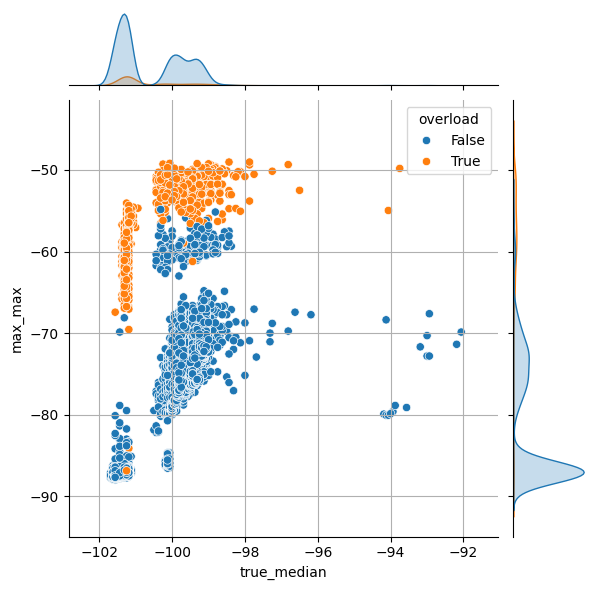

In [13]:
# All sensors, all channels 
new_plotter.plot_summary()

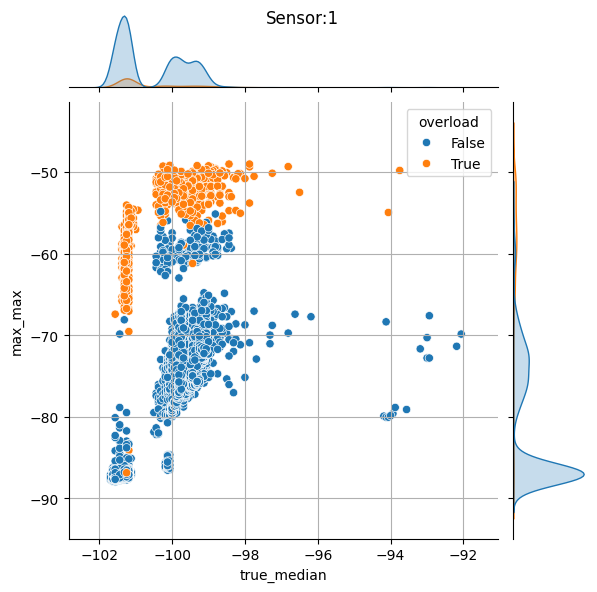

In [14]:
# One sensor, all channels 
new_plotter.plot_summary_by_sensor(sensor_id =1)

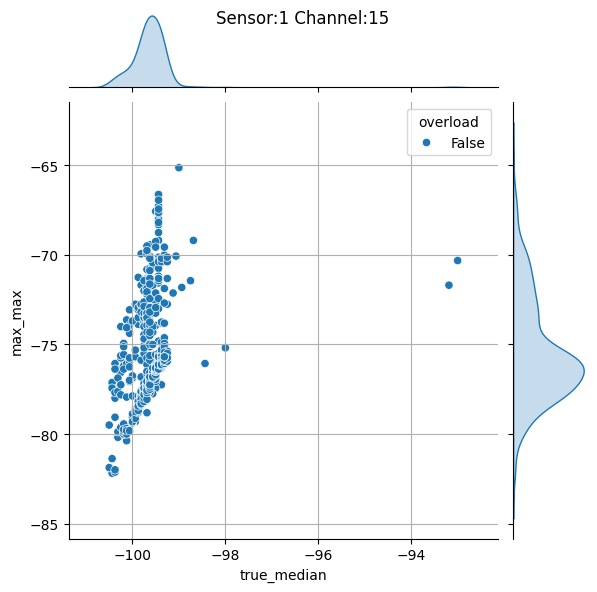

In [15]:
# One sensor, one channel 
new_plotter.plot_summary_by_sensor_channel(sensor_id =1,channel_id=15)

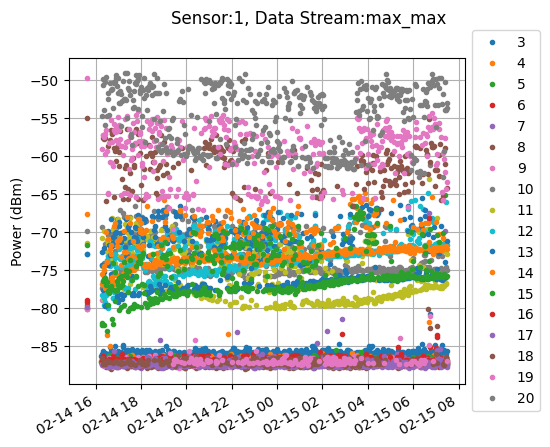

In [16]:
# All max of max time data for a single sensor
new_plotter.plot_time_by_sensor(sensor_id=1,stream="max_max")

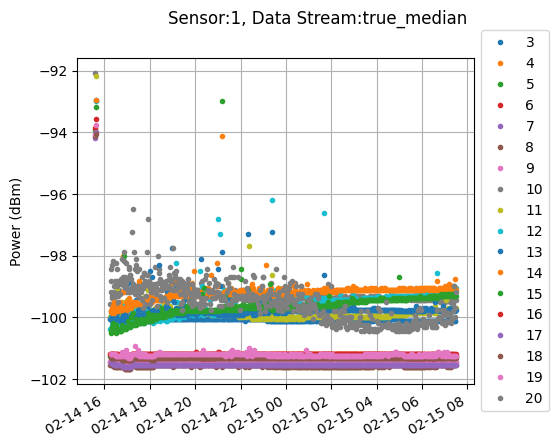

In [17]:
# All true median time data for a single sensor
new_plotter.plot_time_by_sensor(sensor_id=1,stream="true_median")

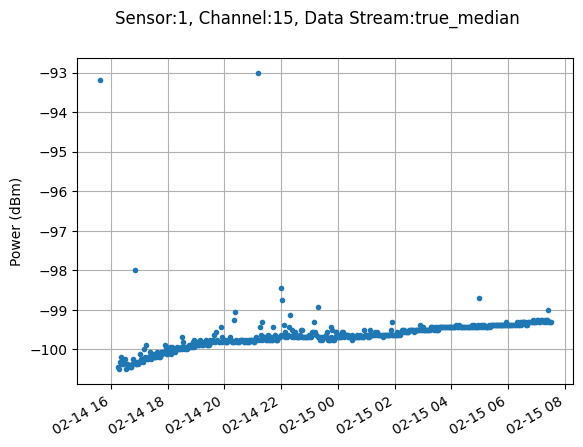

In [18]:
# All true median time data for a single sensor,single channel
new_plotter.plot_time_by_sensor_channel(sensor_id=1,channel_id = 15,stream="true_median")

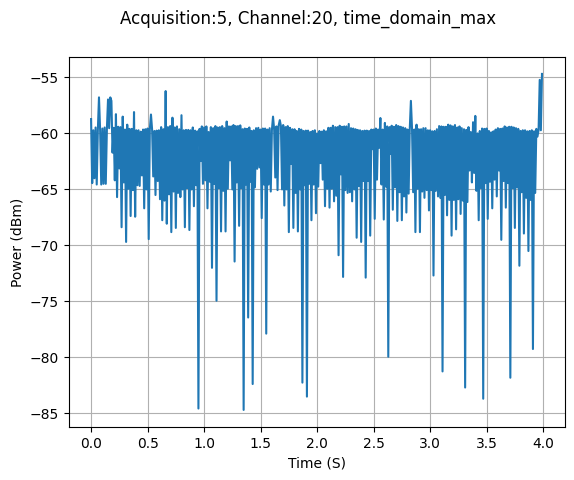

In [19]:
new_plotter.plot_data_by_acquistion_channel(acquisition_id =5, channel_id = 20,table="time_domain_max")

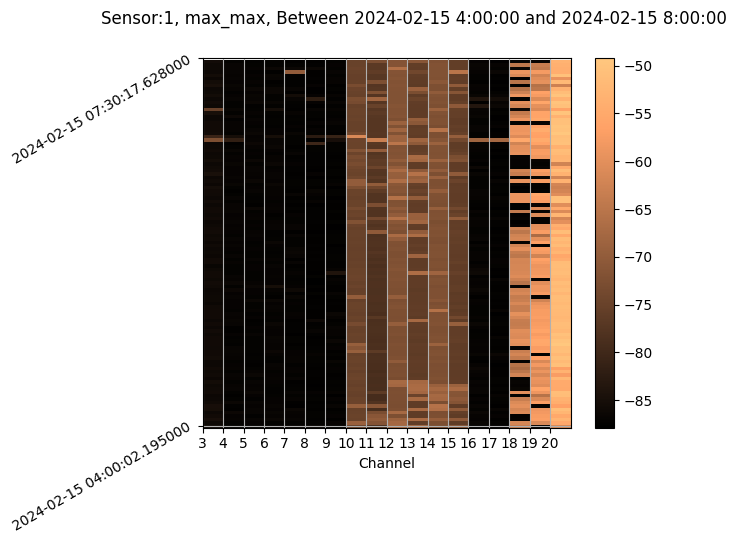

In [20]:
new_plotter.plot_value_frequency_by_date("2024-02-15 4:00:00","2024-02-15 8:00:00",1,"max_max","copper")

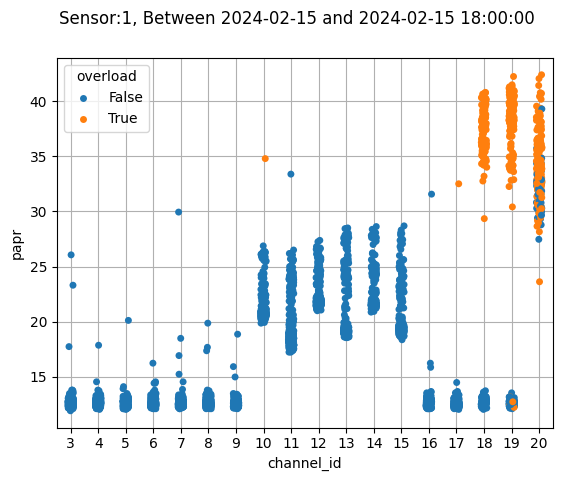

In [21]:
new_plotter.plot_papr_by_date("2024-02-15","2024-02-15 18:00:00",1)

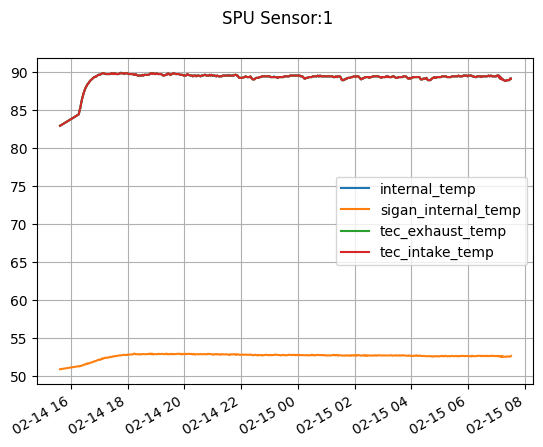

In [22]:
new_plotter.plot_spu_diagnostic_temps_by_sensor(1)

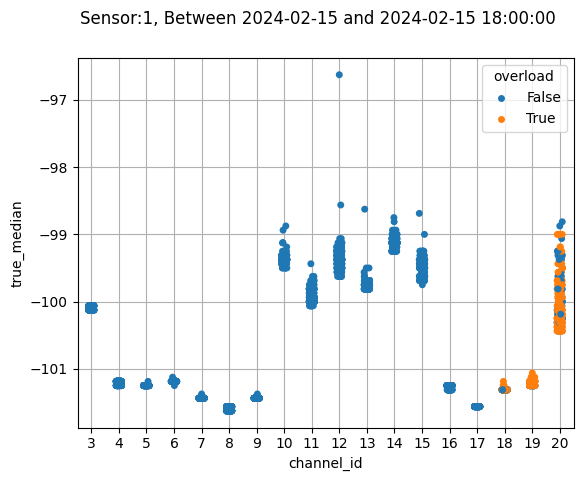

In [23]:
new_plotter.plot_strip_by_date("2024-02-15","2024-02-15 18:00:00",1,"true_median")